In [223]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM
from tensorflow.python.keras.layers import CuDNNLSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers


%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)



In [224]:
df = pd.read_csv("......//.csv",parse_dates=['Date'])
cols = [0]
df.drop(df.columns[cols],axis=1,inplace=True)

df.head(10)

In [249]:
df.head(10)

,Date,Close
0,2013-10-01,123.65499
1,2013-10-02,125.45500
2,2013-10-03,108.58483
3,2013-10-04,118.67466
4,2013-10-05,121.33866
5,2013-10-06,120.65533
6,2013-10-07,121.79500
7,2013-10-08,123.03300
8,2013-10-09,124.04900
9,2013-10-10,125.96116


Text(0, 0.5, 'Close Price (USD)')

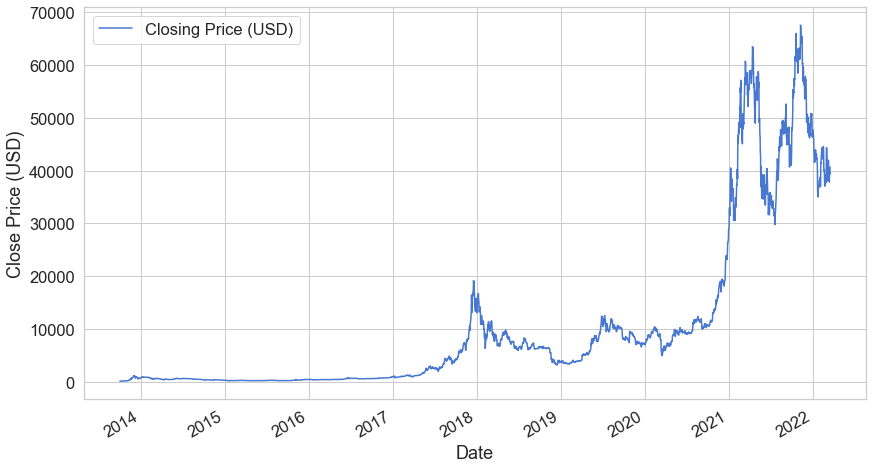

In [228]:
ax = df.plot(x='Date', y='Closing Price (USD)');
ax.set_xlabel("Date")
ax.set_ylabel("Close Price (USD)")

In [237]:
df = df.rename(columns = {'Date' : 'Date', 'Closing Price (USD)' : 'Close'})


scaler = MinMaxScaler()

close_price = df.Close.values.reshape(-1, 1)

scaled_close = scaler.fit_transform(close_price)

In [240]:
scaled_close = scaled_close[~np.isnan(scaled_close)]
scaled_close = scaled_close.reshape(-1, 1)

In [250]:
SEQ_LEN = 100
def to_sequences(data, seq_len):
    d = []
    for index in range(len(data) - seq_len):
        d.append(data[index: index + seq_len])
    return np.array(d)
def preprocess(data_raw, seq_len, train_split):
    data = to_sequences(data_raw, seq_len)
    num_train = int(train_split * data.shape[0])
    X_train = data[:num_train, :-1, :]
    y_train = data[:num_train, -1, :]
    X_test = data[num_train:, :-1, :]
    y_test = data[num_train:, -1, :]
    return X_train, y_train, X_test, y_test
X_train, y_train, X_test, y_test =\
 preprocess(scaled_close, SEQ_LEN, train_split = 0.80)

In [259]:
X_test.shape

(592, 99, 1)

In [260]:
X_train.shape

(2364, 99, 1)

In [253]:

model = tf.keras.Sequential()
model.add(layers.LSTM(units=32, return_sequences=True,
                  input_shape=(99,1), dropout=0.2))
model.add(layers.LSTM(units=32, return_sequences=True,
                  dropout=0.2))
model.add(layers.LSTM(units=32, dropout=0.2))
model.add(layers.Dense(units=1))
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_21 (LSTM)               (None, 99, 32)            4352      
_________________________________________________________________
lstm_22 (LSTM)               (None, 99, 32)            8320      
_________________________________________________________________
lstm_23 (LSTM)               (None, 32)                8320      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 33        
Total params: 21,025
Trainable params: 21,025
Non-trainable params: 0
_________________________________________________________________


In [254]:
model.compile(
    loss='mean_squared_error', 
    optimizer='adam'
)

In [255]:
BATCH_SIZE = 64

history = model.fit(
    X_train, 
    y_train, 
    epochs=5, 
    batch_size=BATCH_SIZE, 
    shuffle=False,
    validation_split=0.1
)

Train on 2127 samples, validate on 237 samples
Epoch 1/5


2022-03-23 14:30:37.860137: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference___backward_standard_lstm_99797_100282_specialized_for_StatefulPartitionedCall_at___inference_distributed_function_101473' and '__inference___backward_cudnn_lstm_with_fallback_99502_99684' both implement 'lstm_e36711c7-ab06-491b-967f-4b646b910498' but their signatures do not match.


2112/2127 [============================>.] - ETA: 0s - loss: 0.0011

2022-03-23 14:31:25.769864: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference_standard_lstm_101736_specialized_for_sequential_8_lstm_21_StatefulPartitionedCall_at___inference_distributed_function_103011' and '__inference_standard_lstm_101736' both implement 'lstm_3948b614-2582-42ed-bef9-3f1581421d95' but their signatures do not match.


2127/2127 [==============================] - 88s 41ms/sample - loss: 0.0011 - val_loss: 6.3219e-04
Epoch 2/5
2127/2127 [==============================] - 34s 16ms/sample - loss: 0.0014 - val_loss: 3.5509e-04
Epoch 3/5
2127/2127 [==============================] - 33s 16ms/sample - loss: 0.0027 - val_loss: 5.8874e-04
Epoch 4/5
2127/2127 [==============================] - 35s 16ms/sample - loss: 0.0026 - val_loss: 4.7094e-04
Epoch 5/5
2127/2127 [==============================] - 32s 15ms/sample - loss: 0.0027 - val_loss: 6.5735e-04


In [256]:
model.evaluate(X_test, y_test)

592/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

0.013441997602254757

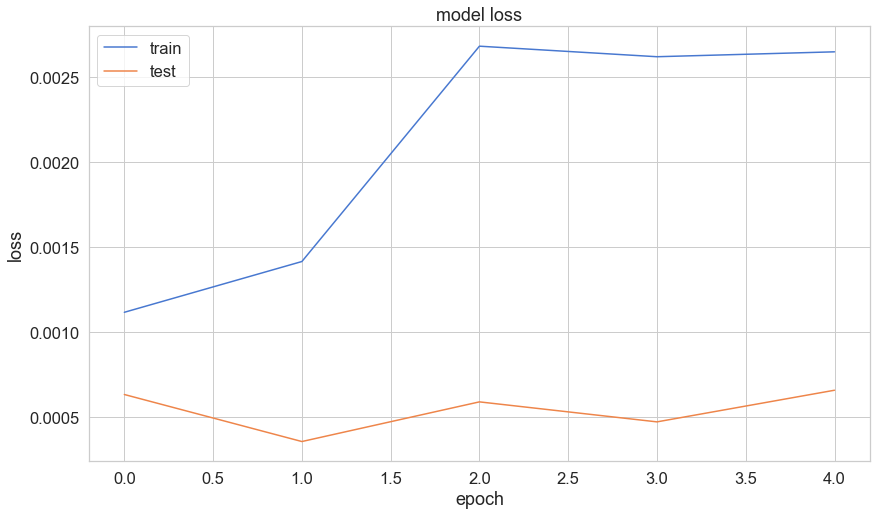

In [257]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

2022-03-23 14:33:50.491973: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference_cudnn_lstm_with_fallback_104727' and '__inference_standard_lstm_104616_specialized_for_sequential_8_lstm_23_StatefulPartitionedCall_at___inference_distributed_function_104918' both implement 'lstm_2fcfc8b7-aafa-4aa4-80a4-39da9d64788f' but their signatures do not match.


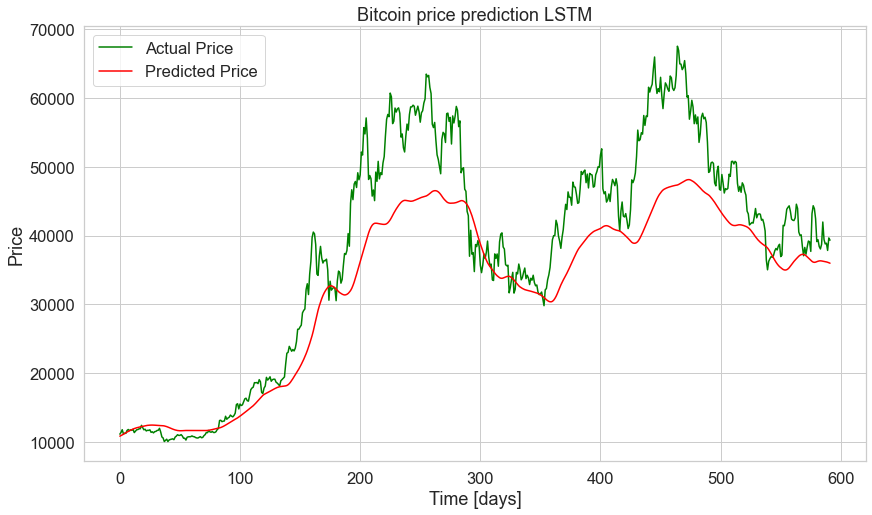

In [258]:
y_hat = model.predict(X_test)

y_test_inverse = scaler.inverse_transform(y_test)
y_hat_inverse = scaler.inverse_transform(y_hat)
 
plt.plot(y_test_inverse, label="Actual Price", color='green')
plt.plot(y_hat_inverse, label="Predicted Price", color='red')
 
plt.title('Bitcoin price prediction LSTM')
plt.xlabel('Time [days]')
plt.ylabel('Price')
plt.legend(loc='best')
 
plt.show();